In [4]:
import QuantLib as ql
import pandas as pd
import numpy as np
from itertools import combinations_with_replacement
import matplotlib.pyplot as plt
from scipy.optimize import minimize

In [18]:
def bond_data(evaluation_date, calendar):
    ql.Settings.instance().evaluationDate = evaluation_date
    bonds = [
    {
        "name": "US 2Y",
        "maturity_label": "2Y",
        "issue_date": ql.Date(15, 8, 2023),
        "maturity_date": ql.Date(15, 8, 2025),
        "coupon_rate": 0.0400,
        "face_value": 100,
        "frequency": ql.Semiannual,
        "calendar": calendar,
        "business_convention": ql.Unadjusted,
        "date_generation": ql.DateGeneration.Backward,
        "day_count": ql.ActualActual(ql.ActualActual.Bond),
        "market_yield": 0.0450
    },
    {
        "name": "US 5Y",
        "maturity_label": "5Y",
        "issue_date": ql.Date(15, 7, 2023),
        "maturity_date": ql.Date(15, 7, 2028),
        "coupon_rate": 0.0445,
        "face_value": 100,
        "frequency": ql.Semiannual,
        "calendar": calendar,
        "business_convention": ql.Unadjusted,
        "date_generation": ql.DateGeneration.Backward,
        "day_count": ql.ActualActual(ql.ActualActual.Bond),
        "market_yield": 0.0480
    },
    {
        "name": "US 10Y",
        "maturity_label": "10Y",
        "issue_date": ql.Date(1, 11, 2022),
        "maturity_date": ql.Date(1, 11, 2032),
        "coupon_rate": 0.0395,
        "face_value": 100,
        "frequency": ql.Semiannual,
        "calendar": calendar,
        "business_convention": ql.Unadjusted,
        "date_generation": ql.DateGeneration.Backward,
        "day_count": ql.ActualActual(ql.ActualActual.Bond),
        "market_yield": 0.0494
    },
    {
        "name": "US 30Y",
        "maturity_label": "30Y",
        "issue_date": ql.Date(30, 9, 2020),
        "maturity_date": ql.Date(30, 9, 2050),
        "coupon_rate": 0.0350,
        "face_value": 100,
        "frequency": ql.Semiannual,
        "calendar": calendar,
        "business_convention": ql.Unadjusted,
        "date_generation": ql.DateGeneration.Backward,
        "day_count": ql.ActualActual(ql.ActualActual.Bond),
        "market_yield": 0.0555
    }
    ]
    return bonds


def bond_analysis(bonds, settlement_date):
    results = []

    for bond_data in bonds:
        schedule = ql.Schedule(
            bond_data["issue_date"],
            bond_data["maturity_date"],
            ql.Period(bond_data["frequency"]),
            bond_data["calendar"],
            bond_data["business_convention"],
            bond_data["business_convention"],
            bond_data["date_generation"],
            False
            )

        bond = ql.FixedRateBond(
            0,
            bond_data["face_value"],
            schedule,
            [bond_data["coupon_rate"]],
            bond_data["day_count"]
        )

        convexity = ql.BondFunctions.convexity(
            bond,
            bond_data["market_yield"],
            bond_data["day_count"],
            ql.Compounded,
            bond_data["frequency"],
            settlement_date
        )

        duration = ql.BondFunctions.duration(
            bond,
            bond_data["market_yield"],
            bond_data["day_count"],
            ql.Compounded,
            bond_data["frequency"],
           ql.Duration.Modified,
           settlement_date
        )

        results.append({
            "Bond": bond_data["name"],
            "Maturity": bond_data["maturity_label"],
            "Coupon": bond_data["coupon_rate"],
            "Yield": bond_data["market_yield"],
            "Convexity": convexity,
            "Duration": duration
        })

    df = pd.DataFrame(results)
    print("\n📈 Bond Analytics:")
    print(df.to_string(index=False))
    return df


def barbell_analysis(df):
    bond_names = df['Bond'].tolist()
    bond_indices = {name: idx for idx, name in enumerate(bond_names)}
    combos = list(combinations_with_replacement(bond_names, 2))
    weights = np.linspace(0, 1, 21)  
    barbell_results = []
    for combo in combos:
        bond1 = combo[0]
        bond2 = combo[1]
        bond1_data = df[df['Bond'] == bond1].iloc[0]
        bond2_data = df[df['Bond'] == bond2].iloc[0]

        for w1 in weights:
            w2 = 1 - w1
            port_duration = w1 * bond1_data["Duration"] + w2 * bond2_data["Duration"]
            port_convexity = w1 * bond1_data["Convexity"] + w2 * bond2_data["Convexity"]
            port_yield = w1 * bond1_data["Yield"] + w2 * bond2_data["Yield"]
            c_d_ratio = port_convexity / port_duration if port_duration > 0 else 0
            barbell_results.append({
                "Bond1": bond1,
                "Bond2": bond2,
                "Weight_1": round(w1, 2),
                "Weight_2": round(w2, 2),
                "Duration": port_duration,
                "Convexity": port_convexity,
                "Yield": port_yield,
                "Convexity/Duration": c_d_ratio
            })
    barbell_df = pd.DataFrame(barbell_results)
    return barbell_df


def convexity_duration_scenario(barbell_df):
    optimal_convexity_duration = barbell_df.sort_values(by="Convexity/Duration", ascending=False).head(5)
    print("\n🔝 Top 5 Portfolios with Highest Convexity/Duration Ratio (Higher Convexity, Lower Duration):")
    print(optimal_convexity_duration.to_string(index=False))


def balanced_scenario(barbell_df):
    min_yield = 0.045 
    min_duration = 3   
    max_duration = 10  

    balanced_portfolios = barbell_df[
        (barbell_df['Yield'] >= min_yield) & 
        (barbell_df['Duration'] >= min_duration) & 
        (barbell_df['Duration'] <= max_duration)
    ]
    print("\n⚖️ Balanced Portfolios with Constraints on Yield and Duration:")
    print(balanced_portfolios.to_string(index=False))
    return balanced_portfolios


def bonds_analysed(bond_data):
    ql.Settings.instance().evaluationDate = ql.Date(12, 4, 2025)
    face_value = 100
    frequency = ql.Semiannual
    calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
    convention = ql.Unadjusted
    day_count = ql.ActualActual(ql.ActualActual.Bond)
    generation = ql.DateGeneration.Backward
    names, durations, convexities, yields, coupons = [], [], [], [], []
    for b in bond_data:
        schedule = ql.Schedule(b["issue_date"], b["maturity_date"], ql.Period(frequency),
                           calendar, convention, convention, generation, False)
        bond = ql.FixedRateBond(0, face_value, schedule, [b["coupon_rate"]], day_count)
        yld = b["market_yield"]
        d = ql.BondFunctions.duration(bond, yld, day_count, ql.Compounded, frequency, ql.Duration.Modified)
        c = ql.BondFunctions.convexity(bond, yld, day_count, ql.Compounded, frequency)
        names.append(b["name"])
        durations.append(d)
        convexities.append(c)
        yields.append(yld)
        coupons.append(b["coupon_rate"])
    durations = np.array(durations)
    convexities = np.array(convexities)
    yields = np.array(yields)
    coupons = np.array(coupons)
    n = len(names)
    shock = 0.01  
    def total_return_objective(w):
        duration = np.dot(w, durations)
        convexity = np.dot(w, convexities)
        coupon_income = np.dot(w, coupons)
        price_change = -duration * shock + 0.5 * convexity * shock**2
        total_return = price_change + coupon_income
        return -total_return  

    constraints = [
        {"type": "eq", "fun": lambda w: np.sum(w) - 1},
        {"type": "ineq", "fun": lambda w: np.dot(w, yields) - 0.045}  #
    ]
    bounds = [(0.05, 0.60)] * n
    x0 = np.array([1/n] * n)
    result = minimize(total_return_objective, x0, bounds=bounds, constraints=constraints)
    weights = result.x
    portfolio_yield = np.dot(weights, yields)
    portfolio_duration = np.dot(weights, durations)
    portfolio_convexity = np.dot(weights, convexities)
    portfolio_coupon_income = np.dot(weights, coupons)
    portfolio_price_change = -portfolio_duration * shock + 0.5 * portfolio_convexity * shock**2
    portfolio_total_return = portfolio_price_change + portfolio_coupon_income
    print("\n✅ Portfolio Summary:")
    for i in range(n):
        print(f"{names[i]} - Yield: {yields[i]:.2%}, Weight: {weights[i]:.2%}, Duration: {durations[i]:.2f}, Convexity: {convexities[i]:.2f}")
    print(f"\n🎯 Portfolio Yield (YTM): {portfolio_yield:.4%}")
    print(f"📏 Portfolio Duration: {portfolio_duration:.2f}")
    print(f"🔁 Portfolio Convexity: {portfolio_convexity:.2f}")
    print(f"💰 Coupon Income: {portfolio_coupon_income:.4%}")
    print(f"📉 Price Change (100bps shock): {portfolio_price_change:.4%}")
    print(f"📈 Total Return (100bps shock): {portfolio_total_return:.4%}")
    return yields, weights, portfolio_duration, portfolio_convexity, portfolio_coupon_income, portfolio_yield
    

def return_sensitivity_analysis(yields, weights, portfolio_duration, portfolio_convexity, portfolio_coupon_income, portfolio_yield):
    shocks = np.linspace(-0.01, 0.01, 9)
    portfolio_returns, portfolio_yields = [], []
    for s in shocks:
        yld_shocked = yields + s
        new_yield = np.dot(weights, yld_shocked)
        portfolio_yields.append(new_yield)
        price_change = -portfolio_duration * s + 0.5 * portfolio_convexity * s**2
        total_return = price_change + portfolio_coupon_income
        portfolio_returns.append(total_return)

    plt.figure(figsize=(10, 6))
    plt.plot(shocks/0.0001, np.array(portfolio_returns) * 100, marker='o', label='Total Return (%)', color='blue')
    plt.plot(shocks/0.0001, np.array(portfolio_yields) * 100, marker='x', label='YTM (%)', color='green')
    plt.axhline(portfolio_yield * 100, linestyle='--', color='gray', label='Initial YTM')
    plt.title("📊 Portfolio Total Return & YTM vs Yield Shocks")
    plt.xlabel("Yield Shock (bps)")
    plt.ylabel("Return / Yield (%)")
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

In [19]:
evaluation_date = ql.Date(12, 4, 2025)
calendar = ql.UnitedStates(ql.UnitedStates.GovernmentBond)
settlement_date = calendar.advance(evaluation_date, 2, ql.Days)

bonds = bond_data(evaluation_date, calendar)
df = bond_analysis(bonds, settlement_date)
barbell_df = barbell_analysis(df)
convexity_duration_scenario(barbell_df)
balanced_portfolios = balanced_scenario(barbell_df)


📈 Bond Analytics:
  Bond Maturity  Coupon  Yield  Convexity  Duration
 US 2Y       2Y  0.0400 0.0450   0.269810  0.329601
 US 5Y       5Y  0.0445 0.0480  10.646659  2.963217
US 10Y      10Y  0.0395 0.0494  46.971316  6.281801
US 30Y      30Y  0.0350 0.0555 311.562088 14.941177

🔝 Top 5 Portfolios with Highest Convexity/Duration Ratio (Higher Convexity, Lower Duration):
 Bond1  Bond2  Weight_1  Weight_2  Duration  Convexity  Yield  Convexity/Duration
 US 2Y US 30Y      0.00      1.00 14.941177 311.562088 0.0555            20.85258
 US 5Y US 30Y      0.00      1.00 14.941177 311.562088 0.0555            20.85258
US 30Y US 30Y      1.00      0.00 14.941177 311.562088 0.0555            20.85258
US 30Y US 30Y      0.35      0.65 14.941177 311.562088 0.0555            20.85258
US 10Y US 30Y      0.00      1.00 14.941177 311.562088 0.0555            20.85258

⚖️ Balanced Portfolios with Constraints on Yield and Duration:
 Bond1  Bond2  Weight_1  Weight_2  Duration  Convexity    Yield  Convex


✅ Portfolio Summary:
US 2Y - Yield: 4.50%, Weight: 60.00%, Duration: 0.33, Convexity: 0.27
US 5Y - Yield: 4.80%, Weight: 30.00%, Duration: 2.97, Convexity: 10.66
US 10Y - Yield: 4.94%, Weight: 5.00%, Duration: 6.28, Convexity: 47.01
US 30Y - Yield: 5.55%, Weight: 5.00%, Duration: 14.94, Convexity: 311.64

🎯 Portfolio Yield (YTM): 4.6645%
📏 Portfolio Duration: 2.15
🔁 Portfolio Convexity: 21.30
💰 Coupon Income: 4.1075%
📉 Price Change (100bps shock): -2.0441%
📈 Total Return (100bps shock): 2.0634%


C:\Users\a-spyrosploussiou\AppData\Local\Temp\5\ipykernel_12816\3355533917.py:255: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
c:\Users\a-spyrosploussiou\AppData\Local\anaconda3_\envs\python_updated\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 128202 (\N{BAR CHART}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


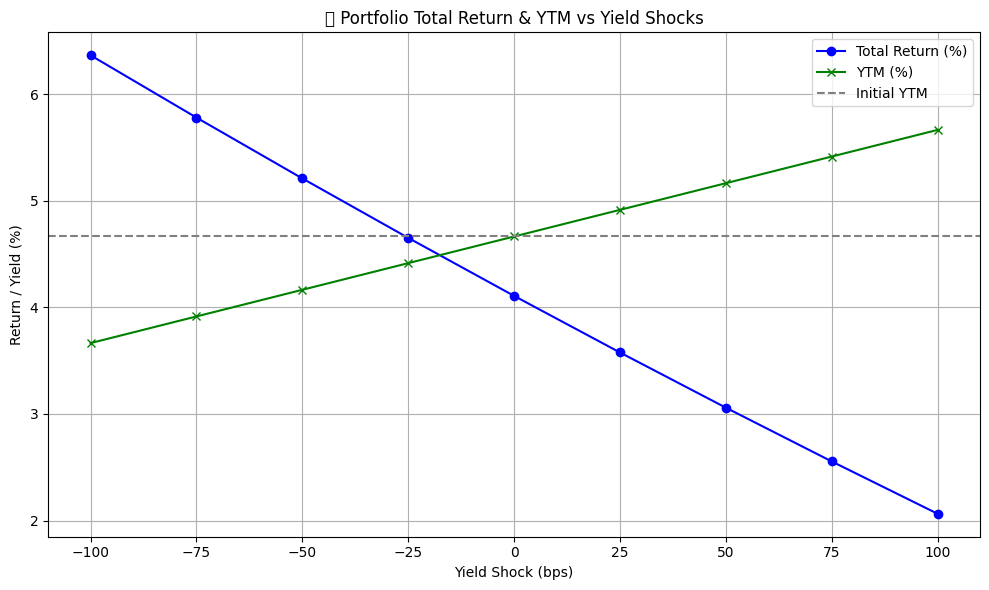

In [20]:
yields, weights, portfolio_duration, portfolio_convexity, portfolio_coupon_income, portfolio_yield=bonds_analysed(bonds)
return_sensitivity_analysis(yields, weights, portfolio_duration, portfolio_convexity, portfolio_coupon_income, portfolio_yield)
